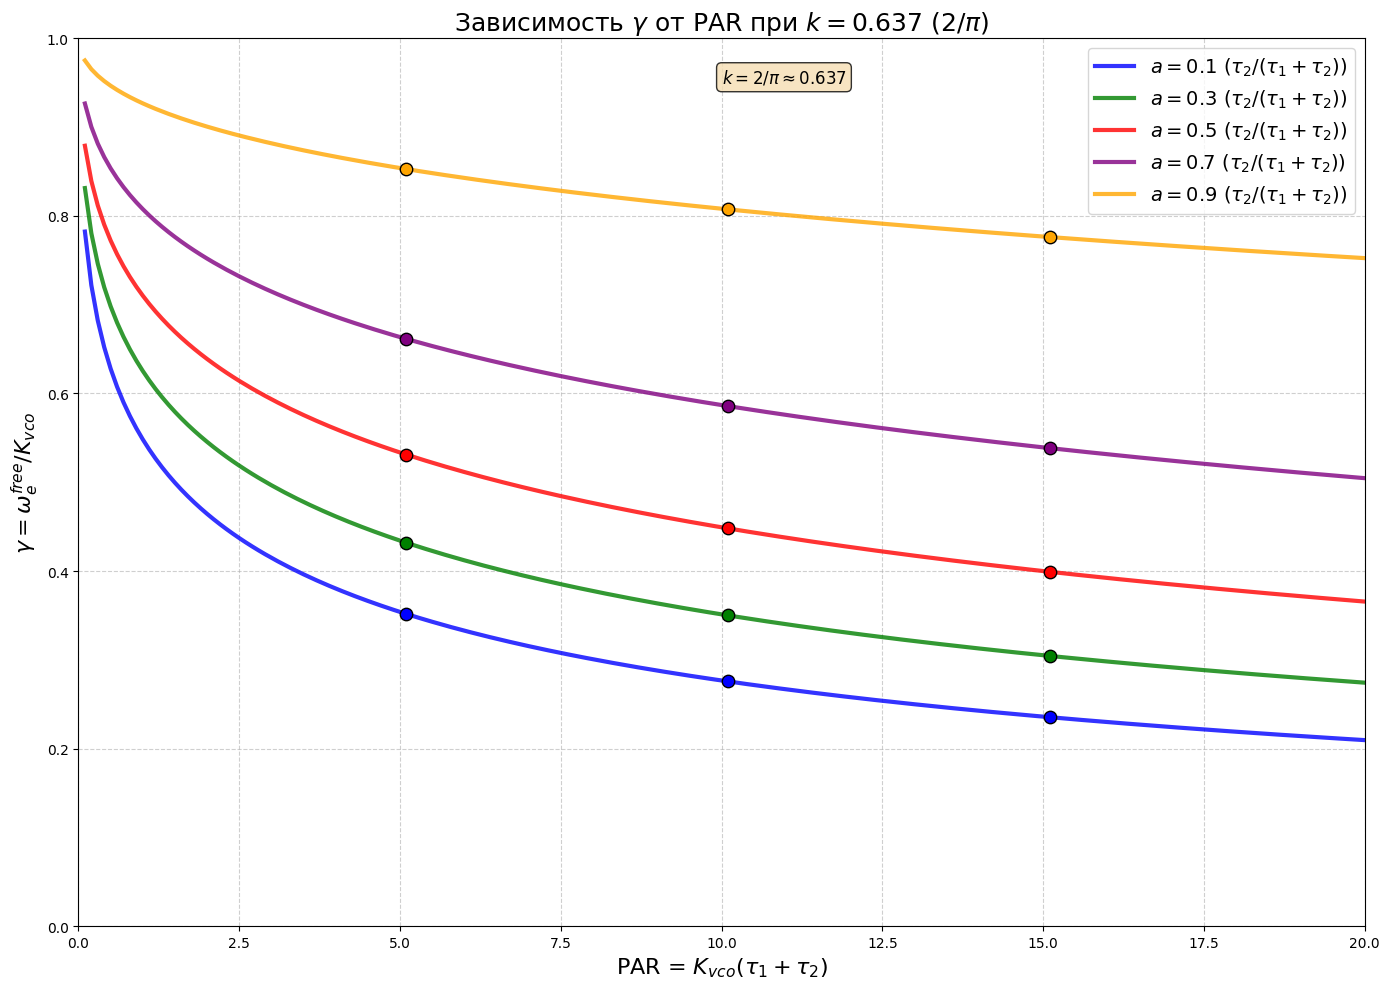

k = 0.6366 (2/π)

Значения γ для различных a и PAR:
------------------------------------------------------------
PAR      a=0.1      a=0.3      a=0.5      a=0.7      a=0.9     
------------------------------------------------------------
0.5      0.6279     0.6981     0.7723     0.8535     0.9466    
1        0.5482     0.6253     0.7101     0.8076     0.9268    
2        0.4644     0.5455     0.6388     0.7519     0.9005    
5        0.3539     0.4342     0.5335     0.6635     0.8539    
10       0.2767     0.3512     0.4492     0.5869     0.8081    
15       0.2360     0.3051     0.3999     0.5392     0.7767    
20       0.2095     0.2742     0.3656     0.5046     0.7524    
------------------------------------------------------------


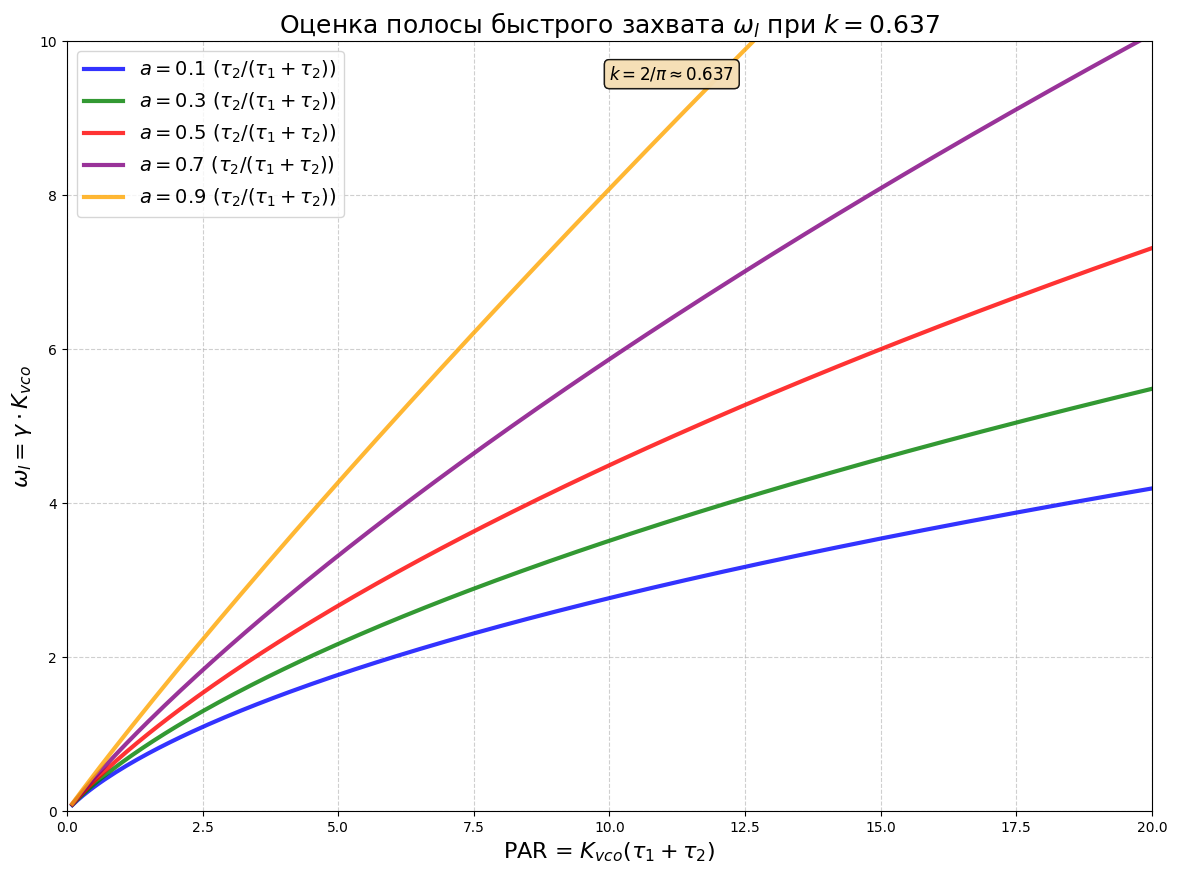

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq

# Заданное значение k
k = 2.0 / np.pi

def equation_for_gamma(gamma, a, PAR):
    """
    Уравнение для нахождения gamma:
    a4*gamma^4 + a3*gamma^3 + a2*gamma^2 + a0 = 0

    Параметры:
    gamma - искомая величина
    a = tau2/(tau1+tau2)
    PAR = K_vco*(tau1+tau2)
    k = 2/pi (задано)

    Возвращает значение уравнения (должно быть 0)
    """
    # Используем соотношения:
    # a = tau2/(tau1+tau2)
    # Пусть tau1+tau2 = T, тогда tau2 = a*T, tau1 = T - tau2 = T(1-a)
    # Для упрощения положим T = tau1+tau2 = 1 (масштабная инвариантность)
    T = 1.0  # tau1+tau2 = 1
    tau2 = a * T  # так как a = tau2/(tau1+tau2)
    tau1 = 1 - a

    # K_vco из PAR: PAR = K_vco * (tau1+tau2) = K_vco * T
    K_vco = PAR / T

    # Вычисляем коэффициенты уравнения с учетом k = 2/pi
    # Общие множители
    common_factor = (tau1 + 2*tau2) / (tau2 * K_vco)

    # Коэффициенты уравнения
    a4 = 2*tau1**2/tau2 + 2*common_factor/k - (np.pi/2)*common_factor
    a3 = -4*common_factor/k
    a2 = 2*tau1**2/tau2 + 2*common_factor/k + np.pi*common_factor
    a0 = -(np.pi/2)*common_factor

    # Уравнение: a4*gamma^4 + a3*gamma^3 + a2*gamma^2 + a0 = 0
    return a4*gamma**4 + a3*gamma**3 + a2*gamma**2 + a0

def find_gamma_for_PAR(PAR, a):
    """
    Находит gamma для заданных PAR и a
    """
    try:
        # Ищем корень уравнения в диапазоне [0, 1]
        # Используем метод Брента, так как он более надежен
        def f(gamma):
            return equation_for_gamma(gamma, a, PAR)

        # Проверяем значения на границах
        f0 = f(0)
        f1 = f(1)

        # Если знаки разные на границах, ищем корень
        if f0 * f1 <= 0:
            try:
                gamma_solution = brentq(f, 0, 1, xtol=1e-12, rtol=1e-12)
                return gamma_solution
            except:
                pass

        # Если не нашли корень методом Брента, пробуем сканирование
        gamma_test = np.linspace(0, 1, 1001)
        eq_values = f(gamma_test)

        # Ищем переход через ноль
        zero_crossings = np.where(np.diff(np.sign(eq_values)))[0]

        if len(zero_crossings) > 0:
            # Берем первый переход через ноль
            idx = zero_crossings[0]
            # Линейная интерполяция для более точного значения
            x1, x2 = gamma_test[idx], gamma_test[idx+1]
            y1, y2 = eq_values[idx], eq_values[idx+1]
            if y1 != y2:
                gamma_solution = x1 - y1 * (x2 - x1) / (y2 - y1)
                return max(0, min(1, gamma_solution))

        return np.nan
    except:
        return np.nan

# Параметры для графиков - линейная сетка
PAR_values = np.linspace(0.1, 20, 200)  # от 0.1 до 20

# Разные значения a = tau2/(tau1+tau2)
a_values = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = [f'$a = {a}$ ($\\tau_2/(\\tau_1+\\tau_2)$)' for a in a_values]

# Создаем график зависимости gamma от PAR
plt.figure(figsize=(14, 10))

# Для каждого значения a строим кривую
for a, color, label in zip(a_values, colors, labels):
    gamma_values = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        gamma_values.append(gamma)

    # Строим график
    plt.plot(PAR_values, gamma_values, color=color, linewidth=3, label=label, alpha=0.8)

    # Добавляем маркеры для некоторых значений
    sample_indices = [50, 100, 150]
    for idx in sample_indices:
        if idx < len(PAR_values) and not np.isnan(gamma_values[idx]):
            plt.scatter(PAR_values[idx], gamma_values[idx], color=color, s=80,
                       edgecolor='black', linewidth=1, zorder=5)

# Настройки графика
plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=16)
plt.ylabel('$\\gamma = \\omega_e^{free}/K_{vco}$', fontsize=16)
plt.title(f'Зависимость $\\gamma$ от PAR при $k = {k:.3f}$ ($2/\\pi$)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')
plt.xlim(0, 20)
plt.ylim(0, 1)


# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# График: зависимость omega_l от PAR (оценка полосы быстрого захвата)
plt.figure(figsize=(14, 10))

for a, color, label in zip(a_values, colors, labels):
    gamma_values = []
    omega_l_values = []
    valid_PAR = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        if not np.isnan(gamma):
            gamma_values.append(gamma)
            # omega_l = gamma * K_vco
            # При (tau1+tau2)=1, K_vco = PAR
            omega_l = gamma * PAR
            omega_l_values.append(omega_l)
            valid_PAR.append(PAR)

    # Строим график omega_l
    if omega_l_values:
        plt.plot(valid_PAR, omega_l_values, color=color,
                linewidth=3, label=f'{label}', alpha=0.8)

plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=16)
plt.ylabel('$\\omega_l = \\gamma \\cdot K_{vco}$', fontsize=16)
plt.title(f'Оценка полосы быстрого захвата $\\omega_l$ при $k = {k:.3f}$', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper left')
plt.xlim(0, 20)
plt.ylim(0, 10)

# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))



# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))



# Сводная таблица значений для некоторых точек
print(f"k = {k:.4f} (2/π)")
print("\nЗначения γ для различных a и PAR:")
print("-" * 60)
print(f"{'PAR':<8} {'a=0.1':<10} {'a=0.3':<10} {'a=0.5':<10} {'a=0.7':<10} {'a=0.9':<10}")
print("-" * 60)

for PAR in [0.5, 1, 2, 5, 10, 15, 20]:
    row_values = [PAR]
    for a in a_values:
        gamma = find_gamma_for_PAR(PAR, a)
        row_values.append(f"{gamma:.4f}" if not np.isnan(gamma) else "nan")
    print(f"{row_values[0]:<8} {row_values[1]:<10} {row_values[2]:<10} {row_values[3]:<10} {row_values[4]:<10} {row_values[5]:<10}")

print("-" * 60)